In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Activation function (ReLU) and its derivative

# def relu(x):
#     return np.maximum(0, x)

def activation_fn(x):
    return x

# def relu_derivative(x):
#     return np.where(x > 0, 1, 0)


def relu_derivative(x):
    return 1

# Mean Squared Error and its derivative
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return -2 * (y_true - y_pred) / len(y_true)

# Neural Network with multiple optimizers and early stopping
class NeuralNetwork:
    def __init__(self, dim_list,  lr=0.01, epsilon=1e-8):
        self.dim_list = dim_list
        self.lr = lr
        self.epsilon = epsilon
        
        self.weights = []
        self.biases = []
        # Initialize weights and biases        
        for i in range(len(dim_list)-1):
            self.weights.append(np.random.randn(dim_list[i], dim_list[i+1]) )
            self.biases.append(np.zeros((1, dim_list[i+1])))
        

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        for i in range(len(self.weights)):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(Z)
            if i == len(self.weights) - 1:  # No activation for the output layer
                self.activations.append(Z) 
            else:
                self.activations.append(activation_fn(Z))
        
        return self.activations[-1]

    def predict(self, X):
        return self.forward(X)

    def __call__(self, X):
        return self.predict(X)
    
    def backward(self, X, y, y_pred):
        dL_dZ = mse_derivative(y, y_pred)

        # print("dldz = "+str(dL_dZ))
        # print ("activations = "+str(self.activations))
        gradients_weights = []
        gradients_biases = []

        self.z_der = dL_dZ

        last_layer = True

        for i in reversed(range(len(self.weights))):
            dL_dW = np.dot(self.activations[i].T, dL_dZ)
            dL_db = np.sum(dL_dZ, axis=0, keepdims=True)
            gradients_weights.insert(0, dL_dW)
            gradients_biases.insert(0, dL_db)
            
            if i > 0:
                if last_layer:
                    dL_dA_prev = np.dot(dL_dZ, self.weights[i].T)
                    dL_dZ = dL_dA_prev * self.z_values[i - 1]
                    last_layer = False
                else : 
                    dL_dA_prev = np.dot(dL_dZ, self.weights[i].T)
                    dL_dZ = dL_dA_prev * relu_derivative(self.z_values[i - 1])
        
        return gradients_weights, gradients_biases
    
    def update_parameters(self, gradients_weights, gradients_biases, X, y):
        """
        Gradient descent with bold-driver adaptive learning rate:
        - If loss decreases:    lr ← 2 * lr
        - If loss increases:    restore old weights, lr ← lr / 2
        """
        print(self.lr)

        # Compute current loss
        old_loss = mse(y, self.forward(X))

        # Save old weights and biases
        old_weights = [w.copy() for w in self.weights]
        old_biases  = [b.copy() for b in self.biases]

        # --- Try update with current LR ---
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * gradients_weights[i]
            self.biases[i]  -= self.lr * gradients_biases[i]

        # Compute new loss
        new_loss = mse(y, self.forward(X))

        # ----------------------------------------------
        # Case 1: Improvement → double learning rate
        # ----------------------------------------------
        if new_loss <= old_loss:
            self.lr *= 2
            return

        # ----------------------------------------------
        # Case 2: Loss increased → rollback & shrink LR
        # ----------------------------------------------
        # Restore parameters
        self.weights = [w.copy() for w in old_weights]
        self.biases  = [b.copy() for b in old_biases]

        # Reduce learning rate until we get improvement
        while True:
            self.lr /= 2
            if self.lr < 1e-8:
                # Stop trying if LR becomes too small
                break

            # Try update again
            for i in range(len(self.weights)):
                self.weights[i] = old_weights[i] - self.lr * gradients_weights[i]
                self.biases[i]  = old_biases[i]  - self.lr * gradients_biases[i]

            new_loss = mse(y, self.forward(X))

            if new_loss <= old_loss:
                break  # success







    def step(self, X, y, X_val, y_val):
        y_pred = self.forward(X)
        loss = mse(y, y_pred) 
        val_loss = mse(y_val, self.forward(X_val))
        gradients_weights, gradients_biases = self.backward(X, y, y_pred)

        self.update_parameters(gradients_weights, gradients_biases, X, y)
        return loss, val_loss, gradients_weights, gradients_biases 



    def train(self, X, y, X_val, y_val, epochs, patience=10):
        best_loss = float("inf")
        patience_counter = 0
        
        for epoch in range(epochs):
            loss, val_loss = self.step(X, y, X_val, y_val)
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
            
            # # Early stopping check
            # if val_loss < best_loss:
            #     best_loss = val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1
            #     if patience_counter >= patience:
            #         print("Early stopping triggered")
            #         break
    





In [35]:

def generate_data(n, d, noise_variance):
    """Generates random Gaussian data with noise."""
    X = np.random.normal(0, 1, (n, d))
    Xtest = np.random.normal(0, 1, (n, d))
    w_true = np.random.normal(0, 1, (d,1))
    noise = np.random.normal(0, 1, (n, 1))
    y = X @ w_true + noise_variance * noise
    noise2 = np.random.normal(0, 1, (n,1))
    ytest = Xtest @ w_true + noise_variance * noise2
    w_star = np.linalg.pinv(X.T @ X) @ X.T @ y
    norm_factor = np.linalg.norm(w_star)
    w_star = w_star / norm_factor
    y = y / norm_factor
    ytest = ytest / norm_factor
    return (X, y, Xtest, ytest, w_star)


In [36]:
(X, y, Xtest, ytest, w_star) = generate_data(10, 1, .1)



0.2
Epoch 0, Loss: 0.0753, Validation Loss: 0.1282, Gradient norm: 0.06333340436427637
0.2
Epoch 1, Loss: 0.0771, Validation Loss: 0.1318, Gradient norm: 0.030366563230881022
0.2
Epoch 2, Loss: 0.0848, Validation Loss: 0.1400, Gradient norm: 0.019307732156421266
0.2
Epoch 3, Loss: 0.0958, Validation Loss: 0.1503, Gradient norm: 0.016563693721319172
0.2
Epoch 4, Loss: 0.1095, Validation Loss: 0.1622, Gradient norm: 0.01728825202268365
0.2
Epoch 5, Loss: 0.1261, Validation Loss: 0.1758, Gradient norm: 0.019788515399089848
0.2
Epoch 6, Loss: 0.1465, Validation Loss: 0.1916, Gradient norm: 0.023528905078352313
0.2
Epoch 7, Loss: 0.1713, Validation Loss: 0.2102, Gradient norm: 0.02841918821879382
0.2
Epoch 8, Loss: 0.2018, Validation Loss: 0.2321, Gradient norm: 0.03456232444742476
0.2
Epoch 9, Loss: 0.2391, Validation Loss: 0.2582, Gradient norm: 0.042168356727440556
0.2
Epoch 10, Loss: 0.2850, Validation Loss: 0.2895, Gradient norm: 0.05152961646366706
0.2
Epoch 11, Loss: 0.3414, Validati

C:\Users\pietr\AppData\Local\Temp\ipykernel_17788\3523237173.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(-1, 1, 0.001), float(w_star)*(np.arange(-1, 1, 0.001)), color = 'k')


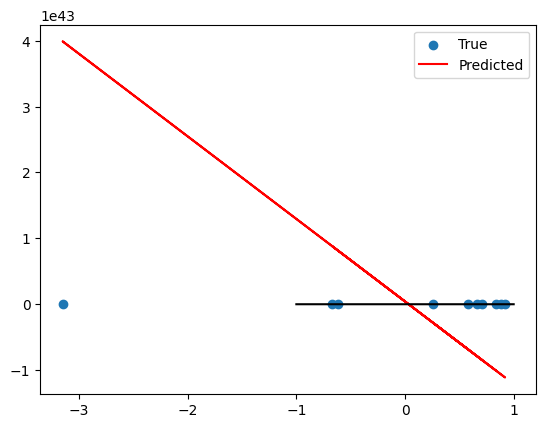

In [37]:
lr = .2
nn = NeuralNetwork([1,1], lr=lr)


best_loss = float("inf")
patience_counter = 0

for epoch in range(1000):
    loss, val_loss, gradients_weights, gradients_biases = nn.step(X, y, Xtest, ytest)
    print(f"Epoch {epoch}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Gradient norm: {np.sum([gw**2 for gw in gradients_weights])+ np.sum([gb**2 for gb in gradients_biases])}")

# Predict
y_pred = nn.predict(X)

# Plot the results (requires matplotlib)
import matplotlib.pyplot as plt
plt.scatter(X, y, label="True")
plt.plot(X, y_pred, color="red", label="Predicted")
plt.plot(np.arange(-1, 1, 0.001), float(w_star)*(np.arange(-1, 1, 0.001)), color = 'k')
plt.legend()
plt.show()


In [38]:
print(nn.weights)
print(nn.biases)
print(np.mean(y))

[array([[-1.25342943e+43]])]
[array([[4.12824338e+41]])]
-0.07135505490624879
